In [1]:
import random

import matplotlib as mpl
import numpy as np
import torch
import torch.utils.data

import theseus as th
import theseus.utils.examples as theg

%load_ext autoreload
%autoreload 2

torch.set_default_dtype(torch.double)

device = "cuda:0" if torch.cuda.is_available else "cpu"
seed = 0
torch.random.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["font.size"] = 16

In [2]:
dataset_dir = "data/motion_planning_2d"
dataset = theg.TrajectoryDataset(True, 2, dataset_dir, map_type="tarpit")
data_loader = torch.utils.data.DataLoader(dataset, 2)

batch = next(iter(data_loader))

In [3]:
for k, v in batch.items():
    if k != "file_id":
        print(f"{k:20s}: {v.shape}")

map_tensor          : torch.Size([2, 128, 128])
sdf_origin          : torch.Size([2, 2])
cell_size           : torch.Size([2, 1])
sdf_data            : torch.Size([2, 128, 128])
expert_trajectory   : torch.Size([2, 4, 101])


<ipython-input-4-0e115706f3c3>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figs[0].show()
<ipython-input-4-0e115706f3c3>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figs[1].show()


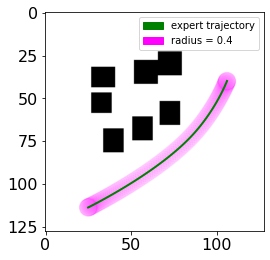

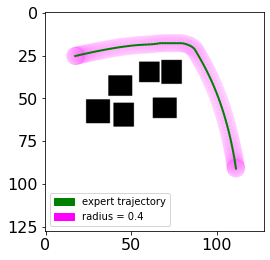

In [4]:
sdf = th.eb.SignedDistanceField2D(
    th.Variable(batch["sdf_origin"]),
    th.Variable(batch["cell_size"]),
    th.Variable(batch["sdf_data"]),
)
figs = theg.generate_trajectory_figs(
    batch["map_tensor"], 
    sdf, 
    [batch["expert_trajectory"]], 
    robot_radius=0.4, 
    labels=["expert trajectory"], 
    fig_idx_robot=0,
    figsize=(4, 4)
)
figs[0].show()
figs[1].show()

In [5]:
trajectory_len = batch["expert_trajectory"].shape[2]
num_time_steps = trajectory_len - 1
map_size = batch["map_tensor"].shape[1]
safety_distance = 0.4
robot_radius = 0.4
total_time = 10.0
dt_val = total_time / num_time_steps
Qc_inv = [[1.0, 0.0], [0.0, 1.0]]
collision_w = 20.0
boundary_w = 100.0

In [6]:
print(trajectory_len)

101


In [7]:
# Create optimization variables
poses = []
velocities = []
for i in range(trajectory_len):
    poses.append(th.Point2(name=f"pose_{i}", dtype=torch.double))
    velocities.append(th.Point2(name=f"vel_{i}", dtype=torch.double))

In [8]:
# Targets for pose boundary cost functions
start_point = th.Point2(name="start")
goal_point = th.Point2(name="goal")

# For collision avoidance cost function
sdf_origin = th.Point2(name="sdf_origin")
cell_size = th.Variable(torch.empty(1, 1), name="cell_size")
sdf_data = th.Variable(torch.empty(1, map_size, map_size), name="sdf_data")
cost_eps = th.Variable(torch.tensor(robot_radius + safety_distance).view(1, 1), name="cost_eps")

# For GP dynamics cost function
dt = th.Variable(torch.tensor(dt_val).view(1, 1), name="dt")

In [9]:
# Cost weight to use for all GP-dynamics cost functions
gp_cost_weight = th.eb.GPCostWeight(torch.tensor(Qc_inv), dt)

# Cost weight to use for all collision-avoidance cost functions
collision_cost_weight = th.ScaleCostWeight(th.Variable(torch.tensor(collision_w)))

# For all hard-constraints (end points pos/vel) we use a single scalar weight
# with high value
boundary_cost_weight = th.ScaleCostWeight(boundary_w)

In [10]:
objective = th.Objective(dtype=torch.double)

In [11]:
# Fixed starting position
objective.add(
    th.eb.VariableDifference(poses[0], boundary_cost_weight, start_point, name="pose_0")
)
# Fixed initial velocity
objective.add(
    th.eb.VariableDifference(
        velocities[0],
        boundary_cost_weight,
        th.Point2(data=torch.zeros(1, 2)),
        name="vel_0",
    )
)
objective.add(
    th.eb.VariableDifference(
        poses[-1], boundary_cost_weight, goal_point, name="pose_N"
    )
)
objective.add(
    th.eb.VariableDifference(
        velocities[-1],
        boundary_cost_weight,
        th.Point2(data=torch.zeros(1, 2)),
        name="vel_N",
    )
)

In [12]:
for i in range(1, trajectory_len - 1):
    objective.add(
        th.eb.Collision2D(
            poses[i],
            collision_cost_weight,
            sdf_origin,
            sdf_data,
            cell_size,
            cost_eps,
            name=f"collision_{i}",
        )
    )

In [13]:
for i in range(1, trajectory_len):
    objective.add(
        (
            th.eb.GPMotionModel(
                poses[i - 1],
                velocities[i - 1],
                poses[i],
                velocities[i],
                dt,
                gp_cost_weight,
                name=f"gp_{i}",
            )
        )
    )

In [34]:
optimizer = th.LevenbergMarquardt(
    objective,
    th.CholeskyDenseSolver,
    max_iterations=3,
    step_size=1.0,
)
motion_planner = th.TheseusLayer(optimizer)
motion_planner.to(device=device, dtype=torch.double)

In [35]:
def get_straight_line_inputs(start, goal):
    # Returns a dictionary with pose and velocity variable names associated to a 
    # straight line trajectory between start and goal
    start_goal_dist = goal - start
    avg_vel = start_goal_dist / total_time
    unit_trajectory_len = start_goal_dist / (trajectory_len - 1)
    input_dict = {}
    for i in range(trajectory_len):
        input_dict[f"pose_{i}"] = start + unit_trajectory_len * i
        if i == 0 or i == trajectory_len - 1:
            input_dict[f"vel_{i}"] = torch.zeros_like(avg_vel)
        else:
            input_dict[f"vel_{i}"] = avg_vel
    return input_dict

In [36]:
start = batch["expert_trajectory"][:, :2, 0].to(device)
goal = batch["expert_trajectory"][:, :2, -1].to(device)
planner_inputs = {
    "sdf_origin": batch["sdf_origin"].to(device),
    "start": start.to(device),
    "goal": goal.to(device),
    "cell_size": batch["cell_size"].to(device),
    "sdf_data": batch["sdf_data"].to(device),
}
planner_inputs.update(get_straight_line_inputs(start, goal))    
with torch.no_grad():        
    final_values, info = motion_planner.forward(
        planner_inputs,
        track_best_solution=True,
        verbose=True,
        damping=0.1, # keyword arguments for optimizer.optimize()
    )

Nonlinear optimizer. Iteration: 0. Error: 3905.6714736579306
Nonlinear optimizer. Iteration: 1. Error: 2282.251394473349
Nonlinear optimizer. Iteration: 2. Error: 136.22542880573795
Nonlinear optimizer. Iteration: 3. Error: 50.78312661084182


In [37]:
def get_trajectory(values_dict):
    trajectory = torch.empty(values_dict[f"pose_0"].shape[0], 4, trajectory_len, device=device)
    for i in range(trajectory_len):
        trajectory[:, :2, i] = values_dict[f"pose_{i}"]
        trajectory[:, 2:, i] = values_dict[f"vel_{i}"]
    return trajectory

<ipython-input-38-2f4509f0a891>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figs[0].show()
<ipython-input-38-2f4509f0a891>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figs[1].show()


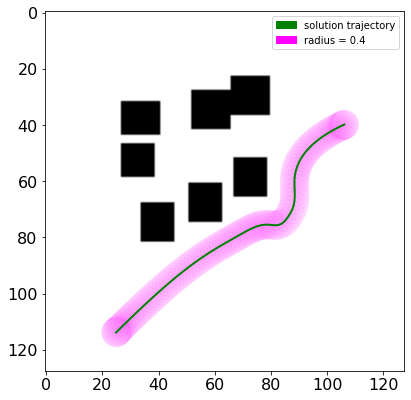

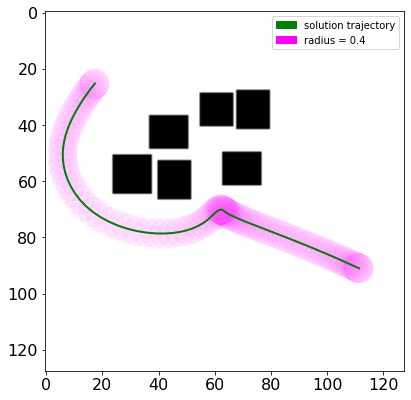

In [38]:
trajectory = get_trajectory(info.best_solution).cpu()

sdf = th.eb.SignedDistanceField2D(
    th.Variable(batch["sdf_origin"]),
    th.Variable(batch["cell_size"]),
    th.Variable(batch["sdf_data"]),
)
figs = theg.generate_trajectory_figs(
    batch["map_tensor"], 
    sdf, 
    [trajectory], 
    robot_radius=robot_radius, 
    labels=["solution trajectory"], 
    fig_idx_robot=0,
    figsize=(6, 6)
)
figs[0].show()
figs[1].show()